In [2]:
import torch
from transformers import AutoProcessor, CLIPModel, AutoTokenizer
from PIL import Image
import requests
import itertools

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")
processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.eval()

c:\Users\kaush\pyenv\ml_env\Lib\site-packages\transformers\utils\generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
c:\Users\kaush\pyenv\ml_env\Lib\site-packages\transformers\utils\generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
c:\Users\kaush\pyenv\ml_env\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e-05,

In [16]:
classes = [
    # PACS data
    'a dog',
    'an elephant',
    'a giraffe',
    'a guitar',
    'a horse',
    'a house',
    'a person',
]
domains = [
    'a photo',
    'a painting',
    'a sculpture',
    'a drawing',
    'a cartoon',
    'a sketch',
    'a diagram',
    'a model',
    'a figure',  
    'a photograph',
    'a mural',
    'a fresco',
    'a lithograph',
    'an etching',
    'a print',
    'a poster',
    'a mixed-media piece',
    'a textile',
    'an animation',
    'a 3D model',
    'a collage',
    'a tapestry',
    'an illustration',
    'a caricature',
    
]

# Components to generate new domain phrases
materials = ['watercolor', 'oil', 'charcoal', 'ink', 'pastel', 'digital', 'acrylic', 'graphite', 'chalk']
styles = ['abstract', 'realistic', 'minimalist', 'expressionist', 'impressionist', 'surrealist', 'cubist', 'geometric', 'pop-art']
formats = ['panorama', 'portrait', 'landscape', 'macro', 'micro', 'aerial', 'fisheye', 'wide-angle', 'time-lapse']
subtypes = ['illustration', 'rendering', 'blueprint', 'schematic', 'map', 'chart', 'poster', 'collage', 'mosaic']

# Expand domains to ~1000 phrases
for style, material, subtype in itertools.product(styles, materials, subtypes):
    if len(domains) >= 1009:
        break
    domains.append(f"a {style} {material} {subtype}")


print(f"Number of domains: {len(domains)}")
print(f"Domains: {domains}")

# Initialize storage for text features
text_features = {cls: None for cls in classes}

# Loop over each class and process all domains in one batch
for cls in classes:
    # Build all text prompts for this class
    texts = [f"{domain} of {cls}" for domain in domains]

    # Tokenize the entire batch at once
    inputs = tokenizer(
        texts,
        return_tensors="pt",
        padding=True,
        truncation=True
    ).to(device)

    # Extract features in one forward pass
    with torch.no_grad():
        feats = model.get_text_features(**inputs)
        # Normalize embeddings
        feats = feats / feats.norm(dim=-1, keepdim=True)

    # Store tensor of shape (num_domains, feature_dim)
    text_features[cls] = feats.cpu()

# Example access:
# text_features['a dog'] is a tensor of size (len(domains), feature_dim)

print({cls: feats.shape for cls, feats in text_features.items()})

Number of domains: 753
Domains: ['a photo', 'a painting', 'a sculpture', 'a drawing', 'a cartoon', 'a sketch', 'a diagram', 'a model', 'a figure', 'a photograph', 'a mural', 'a fresco', 'a lithograph', 'an etching', 'a print', 'a poster', 'a mixed-media piece', 'a textile', 'an animation', 'a 3D model', 'a collage', 'a tapestry', 'an illustration', 'a caricature', 'a abstract watercolor illustration', 'a abstract watercolor rendering', 'a abstract watercolor blueprint', 'a abstract watercolor schematic', 'a abstract watercolor map', 'a abstract watercolor chart', 'a abstract watercolor poster', 'a abstract watercolor collage', 'a abstract watercolor mosaic', 'a abstract oil illustration', 'a abstract oil rendering', 'a abstract oil blueprint', 'a abstract oil schematic', 'a abstract oil map', 'a abstract oil chart', 'a abstract oil poster', 'a abstract oil collage', 'a abstract oil mosaic', 'a abstract charcoal illustration', 'a abstract charcoal rendering', 'a abstract charcoal bluepr

# Visualization of Classes

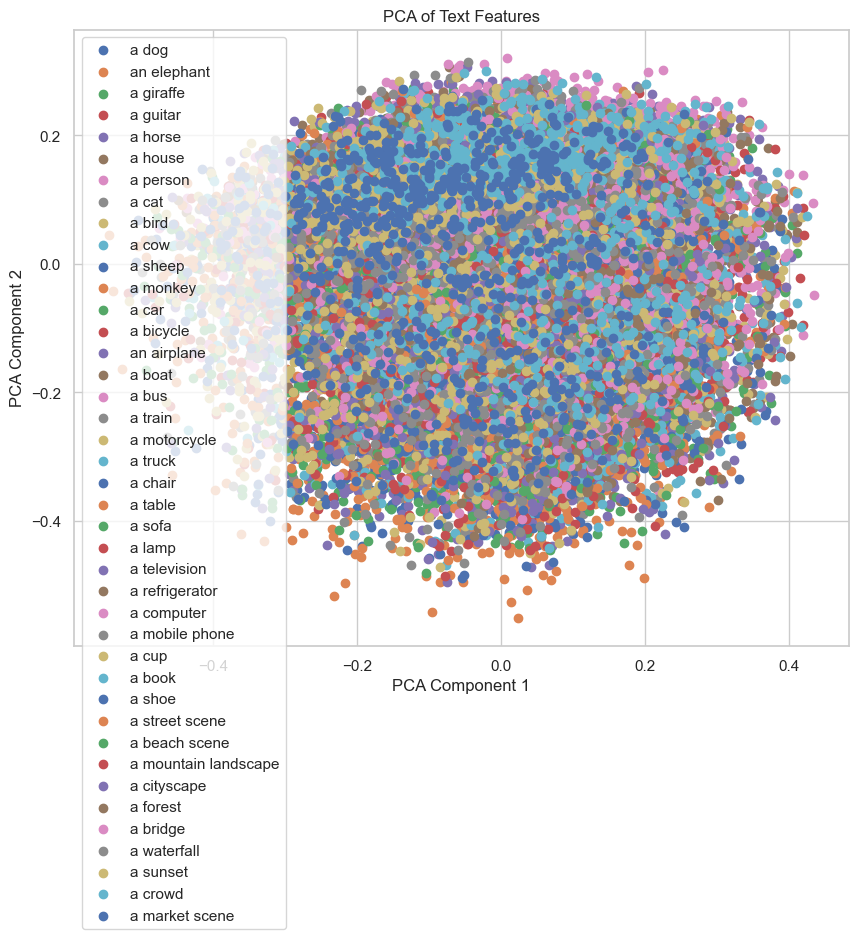

In [11]:
# PCA 
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

pca = PCA(n_components=2)
pca.fit(np.concatenate([tf.numpy() for (key, tf) in text_features.items()], axis=0))

# plot PCA on same figure
plt.figure(figsize=(10, 8))
sns.set(style="whitegrid")

colors = sns.color_palette("deep", len(classes))
i = 0
for cls, tf in text_features.items():
    pca_result = pca.transform(tf.numpy())
    plt.scatter(pca_result[:, 0], pca_result[:, 1], label=cls, color=colors[i])
    i += 1

plt.title("PCA of Text Features")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()

In [12]:
import itertools
import random
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from torch import optim

class Adapter(nn.Module):
    def __init__(self, dim, hidden_dim=512):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, dim),
        )
        self.norm = nn.LayerNorm(dim)

    def forward(self, x):
        return self.norm(x + self.net(x))

# ------------------ Feature Triplet Dataset ------------------
class FeatureTripletDataset(Dataset):
    """
    Constructs triplets (anchor, positive, negative) from text_features.
    text_features: dict[class_key -> Tensor(num_domains, dim)] or list of Tensors.
    """
    def __init__(self, text_features):
        if isinstance(text_features, dict):
            self.class_keys = list(text_features.keys())
            self.features = [text_features[k] for k in self.class_keys]
        else:
            self.features = text_features
            self.class_keys = list(range(len(self.features)))
        # convert all features to CPU float tensors
        self.features = [feat.detach().cpu().float() for feat in self.features]
        self.lengths = [feat.size(0) for feat in self.features]
        self.num_classes = len(self.features)
        if self.num_classes < 2:
            raise ValueError("Need at least 2 classes for triplet generation")

    def __len__(self):
        # define epoch length as total possible anchors
        return sum(self.lengths)

    def __getitem__(self, idx):  # idx ignored for random sampling
        # Sample a class with at least 2 samples
        cls = random.choice([c for c, l in enumerate(self.lengths) if l >= 2])
        n_samples = self.lengths[cls]
        a_idx, p_idx = random.sample(range(n_samples), 2)
        anchor = self.features[cls][a_idx]
        positive = self.features[cls][p_idx]

        # Sample negative class and sample
        neg_cls = random.choice([c for c in range(self.num_classes) if c != cls])
        neg_idx = random.randrange(self.lengths[neg_cls])
        negative = self.features[neg_cls][neg_idx]

        return anchor, positive, negative

# ------------------ Triplet Training ------------------

def cosine_dist(x, y):
    # returns 1 − cosine_similarity, so smaller means more similar
    return 1.0 - F.cosine_similarity(x, y, dim=1)


def train_adapter(
    text_features, device='cuda',
    lr=1e-3, batch_size=256, epochs=10,
    num_workers=0
):
    """
    Train an Adapter using triplet loss on precomputed text_features.

    Args:
        text_features: dict or list of Tensor(num_domains, dim)
        device: 'cuda' or 'cpu'
        lr: learning rate
        batch_size: batch size
        epochs: number of epochs
        num_workers: DataLoader worker count (0 for debug)

    Returns:
        Trained Adapter model
    """
    dataset = FeatureTripletDataset(text_features)
    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=(device=='cuda'),
    )

    # infer feature dimension
    sample_feat = next(iter(dataset))[0]
    dim = sample_feat.size(0)

    adapter = Adapter(dim).to(device)
    loss_fn = nn.TripletMarginWithDistanceLoss(
        margin=0.2, distance_function=cosine_dist, reduction='mean')
    optimizer = optim.Adam(adapter.parameters(), lr=lr)

    adapter.train()
    for epoch in range(1, epochs+1):
        total_loss = 0.0
        for anchor, positive, negative in tqdm(loader, desc=f"Epoch {epoch}"):
            anchor = anchor.to(device)
            positive = positive.to(device)
            negative = negative.to(device)

            out_a = adapter(anchor)
            out_p = adapter(positive)
            out_n = adapter(negative)

            loss = loss_fn(out_a, out_p, out_n)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(loader)
        print(f"Epoch {epoch} — avg loss: {avg_loss:.4f}")

    return adapter

# Example usage:
# adapter = train_adapter(text_features_dict, device='cuda', num_workers=0)


adapter = train_adapter(text_features, device='cuda')
torch.save(adapter.state_dict(), "adapter.pth")


Epoch 1:   0%|          | 0/121 [00:00<?, ?it/s]

Epoch 1: 100%|██████████| 121/121 [00:01<00:00, 60.86it/s]


Epoch 1 — avg loss: 0.0025


Epoch 2: 100%|██████████| 121/121 [00:01<00:00, 72.52it/s]


Epoch 2 — avg loss: 0.0000


Epoch 3: 100%|██████████| 121/121 [00:01<00:00, 72.53it/s]


Epoch 3 — avg loss: 0.0000


Epoch 4: 100%|██████████| 121/121 [00:01<00:00, 73.84it/s]


Epoch 4 — avg loss: 0.0000


Epoch 5: 100%|██████████| 121/121 [00:01<00:00, 70.73it/s]


Epoch 5 — avg loss: 0.0000


Epoch 6: 100%|██████████| 121/121 [00:01<00:00, 74.36it/s]


Epoch 6 — avg loss: 0.0000


Epoch 7: 100%|██████████| 121/121 [00:01<00:00, 74.01it/s]


Epoch 7 — avg loss: 0.0000


Epoch 8: 100%|██████████| 121/121 [00:01<00:00, 72.74it/s]


Epoch 8 — avg loss: 0.0000


Epoch 9: 100%|██████████| 121/121 [00:01<00:00, 73.21it/s]


Epoch 9 — avg loss: 0.0000


Epoch 10: 100%|██████████| 121/121 [00:01<00:00, 72.77it/s]

Epoch 10 — avg loss: 0.0000


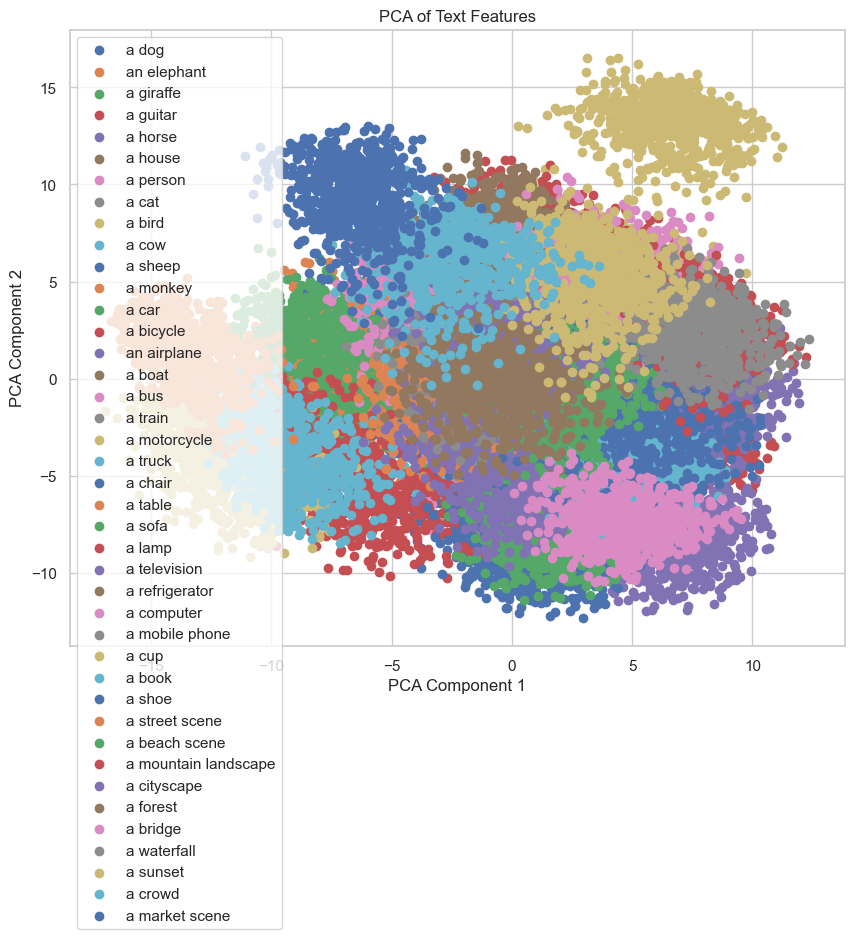

In [13]:
# PCA 
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

adapted_features = {cls: None for cls in classes}
for cls in classes:
    # Apply adapter to each class
    with torch.no_grad():
        adapted_features[cls] = adapter(text_features[cls].to(device)).cpu()

pca = PCA(n_components=2)

pca.fit(np.concatenate([tf.numpy() for (key, tf) in adapted_features.items()], axis=0))

# plot PCA on same figure
plt.figure(figsize=(10, 8))
sns.set(style="whitegrid")

colors = sns.color_palette("deep", len(classes))
i = 0
for cls, tf in adapted_features.items():
    pca_result = pca.transform(tf.numpy())
    plt.scatter(pca_result[:, 0], pca_result[:, 1], label=cls, color=colors[i])
    i += 1

plt.title("PCA of Text Features")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()